In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import seaborn as sns
from pickle import load
from pickle import dump

In [2]:
def print_scores(y, y_pred, model):
    print(
        'Accuracy score: {:.02%}, Precision: {:.02%}, Recall: {:.02%}, F1 score: {:.02%} '.format(
            accuracy_score(y, y_pred),
            precision_score(y, y_pred, pos_label=1),
            recall_score(y, y_pred, pos_label=1),
            f1_score(y, y_pred, pos_label=1)
        ), model
    )

# Novelty detection

In [2]:
# Importing the dataset
normal = pd.read_csv('/Users/yi-chenlin/Desktop/Final project/Bearing/Datasets/bearings/NB.csv')
normal['Fault'] = 1

abnormal = pd.read_csv('/Users/yi-chenlin/Desktop/Final project/Bearing/Datasets/bearings/IR - 7.csv')
abnormal['Fault'] = -1

In [3]:
normal

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
121150,-0.034630,0.025065,1
121151,-0.047147,-0.010684,1
121152,-0.027954,-0.034927,1
121153,-0.010014,-0.046022,1


In [4]:
abnormal

,DE,FE,Fault
0,-0.093238,-0.029175,-1
1,0.187288,-0.186347,-1
2,0.217663,-0.341260,-1
3,0.070172,-0.160871,-1
4,0.100385,0.179978,-1
...,...,...,...
121150,0.135958,-0.047255,-1
121151,-0.083167,-0.070882,-1
121152,0.391469,-0.181005,-1
121153,0.185501,0.136011,-1


In [18]:
dataset = normal.append(abnormal)
dataset = dataset.reset_index(drop=True)
dataset

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
242305,0.135958,-0.047255,-1
242306,-0.083167,-0.070882,-1
242307,0.391469,-0.181005,-1
242308,0.185501,0.136011,-1


In [19]:
normal = dataset[dataset.Fault == 1]
abnormal = dataset[dataset.Fault == -1]

In [20]:
normal

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
121150,-0.034630,0.025065,1
121151,-0.047147,-0.010684,1
121152,-0.027954,-0.034927,1
121153,-0.010014,-0.046022,1


In [21]:
abnormal

,DE,FE,Fault
121155,-0.093238,-0.029175,-1
121156,0.187288,-0.186347,-1
121157,0.217663,-0.341260,-1
121158,0.070172,-0.160871,-1
121159,0.100385,0.179978,-1
...,...,...,...
242305,0.135958,-0.047255,-1
242306,-0.083167,-0.070882,-1
242307,0.391469,-0.181005,-1
242308,0.185501,0.136011,-1


train with normal and test with mix => novelty detection

In [5]:
#X_train, X_test = train_test_split(normal, test_size = 0.3, shuffle=False, random_state = 0)

In [22]:
sc = StandardScaler()
X_inliers = sc.fit_transform(normal[['DE', 'FE']])
X = sc.transform(dataset[['DE', 'FE']])

In [23]:
X_inliers

array([[ 0.82785884,  0.09052428],
       [ 0.80811591,  0.98237156],
       [-0.25471197,  1.45193072],
       ...,
       [-0.62653722, -1.0376783 ],
       [-0.34355516, -1.2078541 ],
       [-0.36658859, -0.08280293]])

In [24]:
y = dataset.iloc[:, 2]

In [25]:
y

0         1
1         1
2         1
3         1
4         1
         ..
242305   -1
242306   -1
242307   -1
242308   -1
242309   -1
Name: Fault, Length: 242310, dtype: int64

## LOF, novelty detection

In [26]:
lof = LocalOutlierFactor(n_neighbors=50,novelty=True)
lof.fit(X_inliers) 
dataset['pred_anomaly'] = lof.predict(X)

In [30]:
print_scores(y, dataset['pred_anomaly'], lof)

Accuracy score: 80.19%, Precision: 71.65%, Recall: 99.91%, F1 score: 83.45%  LocalOutlierFactor(n_neighbors=50, novelty=True)


In [27]:
pred_anomalies = dataset[dataset['pred_anomaly'] == -1]

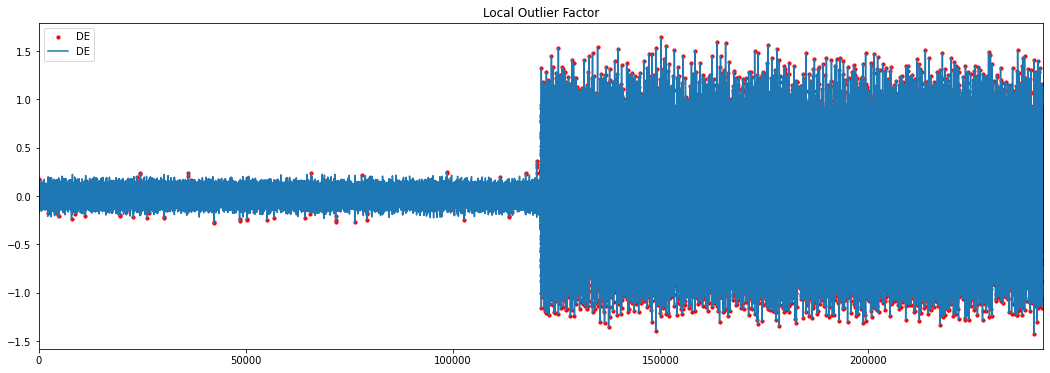

In [28]:
f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(pred_anomalies.index, pred_anomalies.DE, label='DE', color='red', s=10)
ax1.plot(dataset.index, dataset.DE, label='DE');
plt.xlim((0,len(dataset.index)))

plt.title('Local Outlier Factor')
plt.legend();
plt.show();

# Outliers detection

Outliers detection train with both inliers and outliers

In [3]:
# Importing the dataset
normal = pd.read_csv('/Users/yi-chenlin/Desktop/Final project/Bearing/Datasets/bearings/NB.csv')
normal['Fault'] = 1

abnormal = pd.read_csv('/Users/yi-chenlin/Desktop/Final project/Bearing/Datasets/bearings/IR - 7.csv')
abnormal['Fault'] = -1

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(normal, test_size = 0.2, shuffle=False, random_state = 0)

y_train, y_test = train_test_split(abnormal, test_size = 0.2, shuffle=False, random_state = 0)

In [5]:
train = X_train.append(y_train)
train = train.reset_index(drop=True)
train

,DE,FE,Fault
0,0.064254,0.038625,1
1,0.063002,0.096769,1
2,-0.004381,0.127382,1
3,-0.035882,0.144640,1
4,-0.023991,0.086702,1
...,...,...,...
193843,0.138557,-0.357080,-1
193844,0.210678,-0.204016,-1
193845,0.126537,-0.303867,-1
193846,-0.186476,-0.246956,-1


In [6]:
test = X_test.append(y_test)
test = test.reset_index(drop=True)
test

,DE,FE,Fault
0,0.058204,-0.015204,1
1,0.011057,0.005958,1
2,-0.066548,0.066362,1
3,-0.131845,0.110535,1
4,-0.132471,0.096153,1
...,...,...,...
48457,0.135958,-0.047255,-1
48458,-0.083167,-0.070882,-1
48459,0.391469,-0.181005,-1
48460,0.185501,0.136011,-1


### Pickle train and test data for later use

In [7]:
dump(train, open("/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train.pkl", "wb"))
dump(test, open("/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test.pkl", "wb"))

In [8]:
sc = StandardScaler()
train_data = sc.fit_transform(train[['DE', 'FE']])
test_data = sc.transform(test[['DE', 'FE']])

In [9]:
dump(train_data, open("/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train_data.pkl", "wb"))
dump(test_data, open("/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test_data.pkl", "wb"))

In [11]:
outliers_fraction = 0.01

## LOF

## Isolation forest

In [16]:
# load data
train = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train.pkl', 'rb'))
test = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test.pkl', 'rb'))
train_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train_data.pkl', 'rb'))
test_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test_data.pkl', 'rb'))

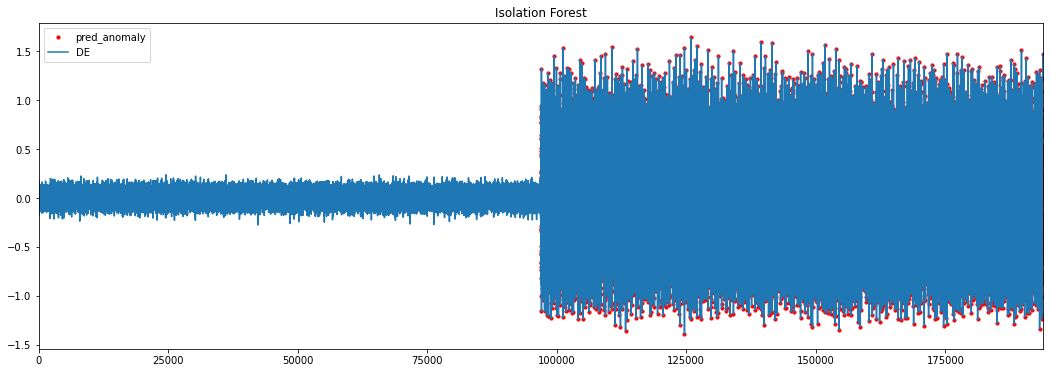

In [17]:
isolationForest =  IsolationForest()
isolationForest.fit(train_data) 
train['pred_anomaly'] = isolationForest.predict(train_data)

# visualization
train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('Isolation Forest')
plt.legend();
plt.show();

print training scores

In [18]:
print_scores(train['Fault'], train['pred_anomaly'], isolationForest)

Accuracy score: 66.43%, Precision: 59.83%, Recall: 100.00%, F1 score: 74.87%  IsolationForest()


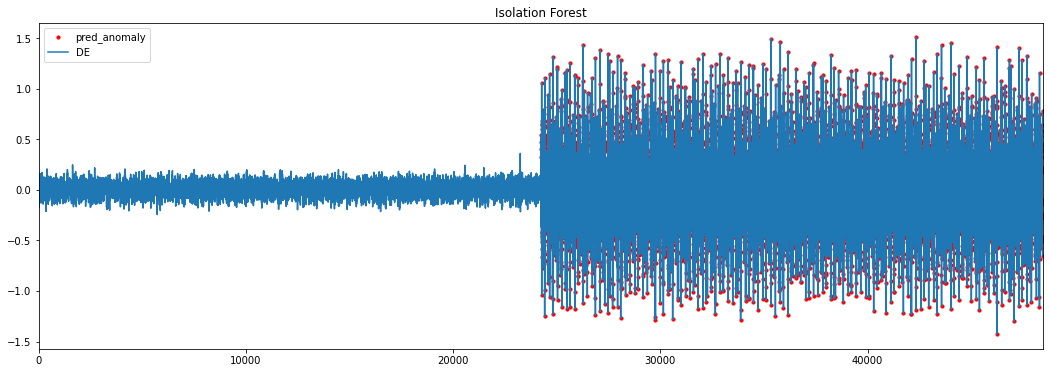

In [19]:
test['pred_anomaly'] = isolationForest.predict(test_data)

# visualization
test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(test.index, test.DE, label='DE');
plt.xlim((0,len(test.index)))

plt.title('Isolation Forest')
plt.legend();
plt.show();

In [20]:
print_scores(test['Fault'], test['pred_anomaly'] , isolationForest)

Accuracy score: 66.60%, Precision: 59.95%, Recall: 100.00%, F1 score: 74.96%  IsolationForest()


## Elliptic Envelope

In [21]:
# load data
train = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train.pkl', 'rb'))
test = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test.pkl', 'rb'))
train_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train_data.pkl', 'rb'))
test_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test_data.pkl', 'rb'))

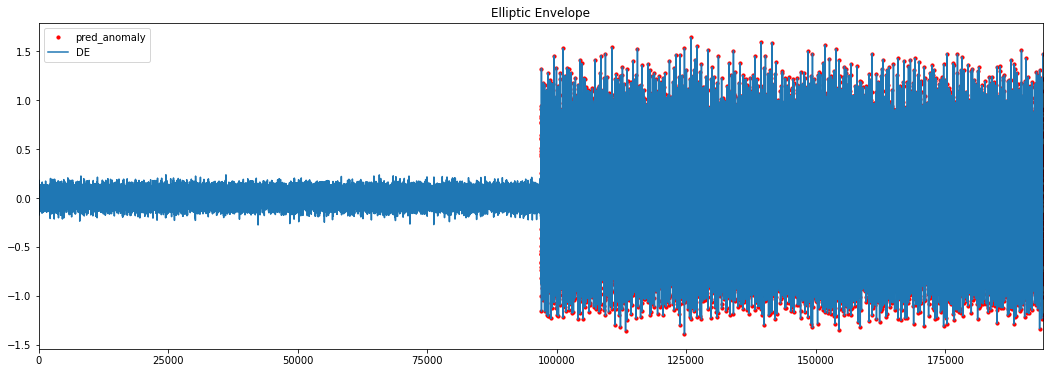

In [22]:
# Elliptic Envelope
ee =  EllipticEnvelope(random_state=0)
train['pred_anomaly'] = ee.fit_predict(train_data)
# visualization
train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('Elliptic Envelope')
plt.legend();
plt.show();

### print training scores

In [23]:
print_scores(train['Fault'], train['pred_anomaly'], ee)

Accuracy score: 60.00%, Precision: 55.56%, Recall: 100.00%, F1 score: 71.43%  EllipticEnvelope(random_state=0)


### Predict on testing data

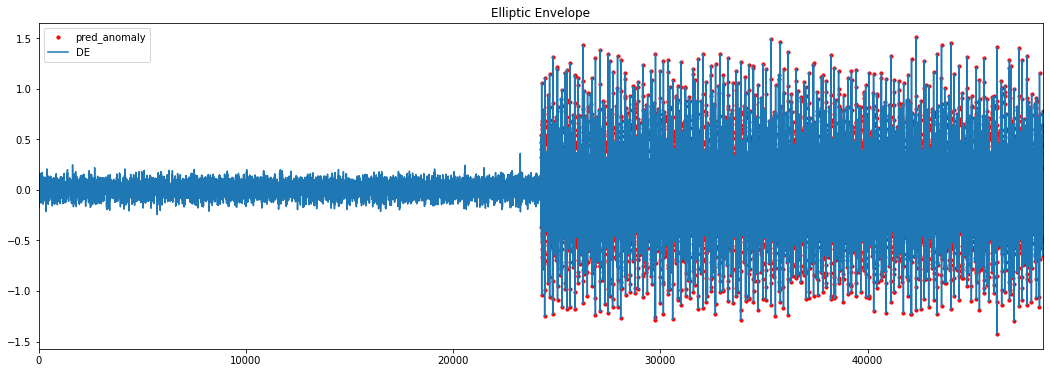

In [24]:
test['pred_anomaly'] = ee.predict(test_data)

# visualization
test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax1) = plt.subplots(figsize=(18, 6))
ax1.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax1.plot(test.index, test.DE, label='DE');
plt.xlim(0, len(test.index))

plt.title('Elliptic Envelope')
plt.legend();
plt.show();

### Print the testing scores

In [25]:
print_scores(test['Fault'], test['pred_anomaly'], ee)

Accuracy score: 60.32%, Precision: 55.75%, Recall: 100.00%, F1 score: 71.59%  EllipticEnvelope(random_state=0)


## One class SVM

### try with nu = outliers_fraction = 0.01 first

In [26]:
# load data
train = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train.pkl', 'rb'))
test = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test.pkl', 'rb'))
train_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train_data.pkl', 'rb'))
test_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test_data.pkl', 'rb'))

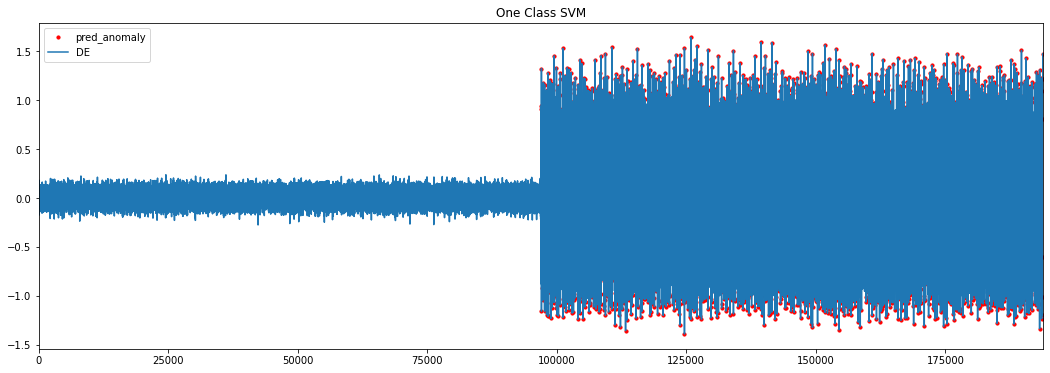

In [27]:
svm = OneClassSVM(nu = outliers_fraction,kernel="rbf", gamma=0.01)
pred_train = svm.fit(train_data)
train['pred_anomaly'] = pd.Series(svm.predict(train_data))

train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('One Class SVM')
plt.legend();
plt.show();

### Print training scores

In [28]:
print_scores(train['Fault'], train['pred_anomaly'], svm)

Accuracy score: 51.00%, Precision: 50.50%, Recall: 100.00%, F1 score: 67.11%  OneClassSVM(gamma=0.01, nu=0.01)


### Predict on test data

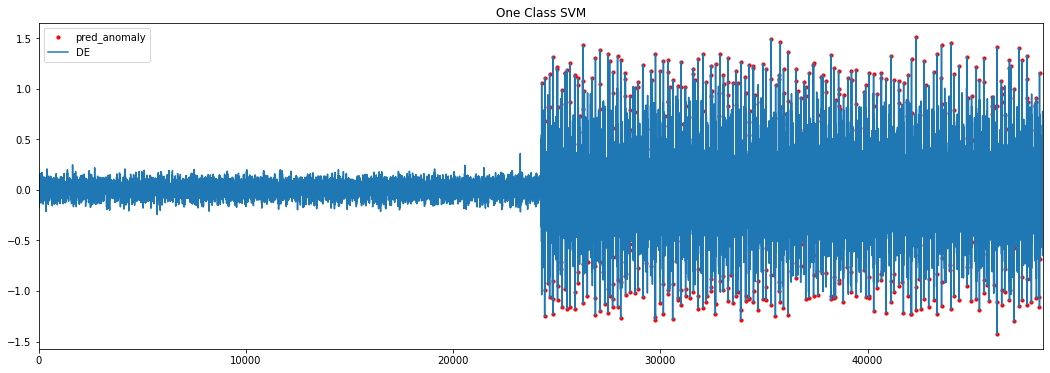

In [30]:
test['pred_anomaly'] = svm.predict(test_data)

test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(test.index, test.DE, label='DE');
plt.xlim(0, len(test.index))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [31]:
print_scores(test['Fault'], test['pred_anomaly'], svm)

Accuracy score: 51.02%, Precision: 50.51%, Recall: 100.00%, F1 score: 67.12%  OneClassSVM(gamma=0.01, nu=0.01)


### Try default nu

In [32]:
# load data
train = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train.pkl', 'rb'))
test = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test.pkl', 'rb'))
train_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/train_data.pkl', 'rb'))
test_data = load(open('/Users/yi-chenlin/Desktop/Final project/pickle/dataset/bearing/test_data.pkl', 'rb'))

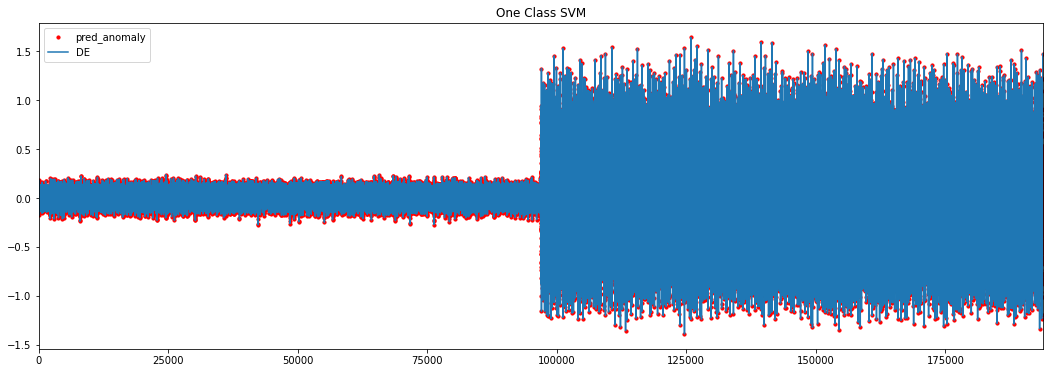

In [33]:
svm = OneClassSVM(kernel="rbf", gamma=0.01)
pred_train = svm.fit(train_data)
train['pred_anomaly'] = pd.Series(svm.predict(train_data))

train_anomalies = train[train['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(train_anomalies.index, train_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(train.index, train.DE, label='DE');
plt.xlim((0,len(train.index)))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [34]:
print_scores(train['Fault'], train['pred_anomaly'], svm)

Accuracy score: 84.83%, Precision: 84.83%, Recall: 84.83%, F1 score: 84.83%  OneClassSVM(gamma=0.01)


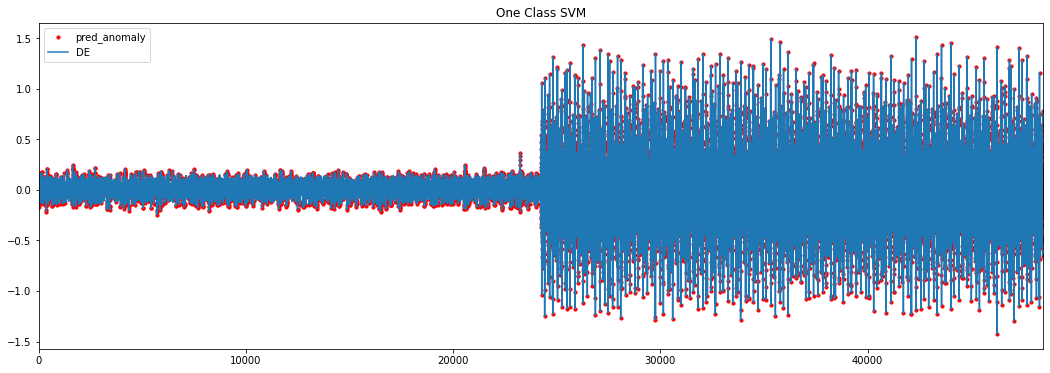

In [35]:
test['pred_anomaly'] = svm.predict(test_data)

test_anomalies = test[test['pred_anomaly'] == -1]

f, (ax3) = plt.subplots(figsize=(18, 6))
ax3.scatter(test_anomalies.index, test_anomalies.DE, label='pred_anomaly', color='red', s=10)
ax3.plot(test.index, test.DE, label='DE');
plt.xlim(0, len(test.index))

plt.title('One Class SVM')
plt.legend();
plt.show();

In [36]:
print_scores(test['Fault'], test['pred_anomaly'], svm)

Accuracy score: 84.51%, Precision: 84.57%, Recall: 84.44%, F1 score: 84.50%  OneClassSVM(gamma=0.01)
